In [1]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="unet")

2025-05-19 14:12:59.383112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747663979.564675      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747663979.620426      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [2]:
def scheduler_name(scheduler):
    return str(type(scheduler)).split('.')[-1][:-2]

In [3]:
from copy import deepcopy, copy

In [4]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device);

In [124]:
from diffusers import DDPMScheduler, DDIMScheduler, LMSDiscreteScheduler, EulerDiscreteScheduler, EulerAncestralDiscreteScheduler, DPMSolverMultistepScheduler
#scheduler = DDPMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")
#scheduler = DDIMScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")
#scheduler = LMSDiscreteScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler") # рисует однотонную серо-зеленую картинку
#scheduler = EulerDiscreteScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler") # рисует однотонную серо-зеленую картинку
scheduler = EulerAncestralDiscreteScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")
#scheduler = DPMSolverMultistepScheduler.from_pretrained("runwayml/stable-diffusion-v1-5", subfolder="scheduler")

In [125]:
prompt = ['A grand piano with a white bench.'] # @param
negative_prompt = [""] #["poorly drawn face, bad face, fused face, ugly face, worst face, asymmetrical, unrealistic skin texture, bad proportions, out of frame, poorly drawn hands, cloned face, double face"] #["worst quality, low quality, low res, blurry, distortion, identifying mark, watermark, ugly"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 50 #@param # Number of denoising steps
guidance_scale = 7.5 #@param # Scale for classifier-free guidance
generator = torch.manual_seed(405)  # Seed generator to create the inital latent noise
batch_size = len(prompt)

# Tokenize the text and generate the embeddings from the prompt
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# generate the unconditional text embeddings which are the embeddings for the padding token. These need to have the same shape (batch_size and seq_length) as the conditional text_embeddings:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(negative_prompt * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

# concatenate the conditional and unconditional embeddings into a batch to avoid doing two forward passes
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [126]:
import gc
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [127]:
# The height and width are divided by 8 because the vae model has 3 down-sampling layers
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)


from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)
branch_step = 10

for t in tqdm(scheduler.timesteps[:branch_step]):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

n = 3 # number of branches
latents = torch.cat([latents] * n)

#new_prompt = prompt * n 
new_prompt = ["A grand piano with a white bench.",
              "photo of beautiful landscape, mountains, river, blue sky, high details, high quality",
              "A robot painted as graffiti on a brick wall. a sidewalk is in front of the wall, and grass is growing out of cracks in the concrete."]
#new_negative_prompt = negative_prompt * n 
new_negative_prompt = ["", 
                       "", 
                       ""]
new_text_input = tokenizer(
    new_prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)
with torch.no_grad():
    new_text_embeddings = text_encoder(new_text_input.input_ids.to(torch_device))[0].reshape((n, 1, 77, 768))

#new_uncond_input = tokenizer([""] * n, padding="max_length", max_length=max_length, return_tensors="pt")
new_uncond_input = tokenizer(new_negative_prompt, padding="max_length", max_length=max_length, return_tensors="pt")
new_uncond_embeddings = text_encoder(new_uncond_input.input_ids.to(torch_device))[0].reshape((n, 1, 77, 768))

# concatenate the conditional and unconditional embeddings into a batch to avoid doing two forward passes
new_text_embeddings = torch.cat([new_uncond_embeddings, new_text_embeddings], dim=1)
new_guidance_scale = 7.5
schedulers = [None] * n
for i in range(n):
    schedulers[i] = copy(scheduler)
for i in range(n):
    for t in tqdm(schedulers[i].timesteps[branch_step:]):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents[i].reshape(1, 4, 64, 64)] * 2)
        #------------------------------------------------------
        #latent_model_input = torch.vstack([latents] * n)
        #text_embeddings = torch.vstack([text_embeddings] * n)
        #------------------------------------------------------
        latent_model_input = schedulers[i].scale_model_input(latent_model_input, timestep=t)
    
        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=new_text_embeddings[i]).sample
    
        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + new_guidance_scale * (noise_pred_text - noise_pred_uncond)
    
        # compute the previous noisy sample x_t -> x_t-1
        latents[i] = schedulers[i].step(noise_pred, t, latents[i].reshape(1, 4, 64, 64)).prev_sample

run += 1

/tmp/ipykernel_31/1412158377.py:3: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

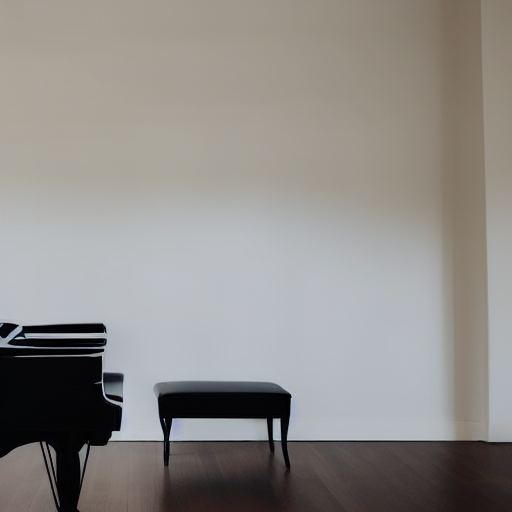

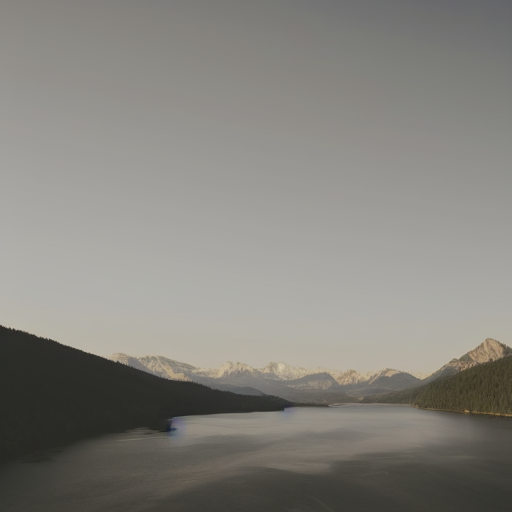

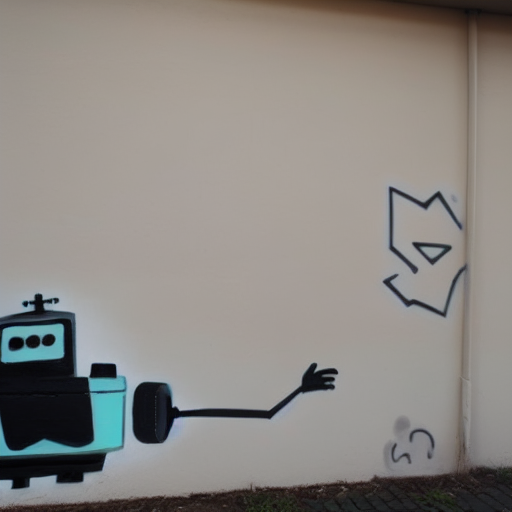

In [128]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
for im in pil_images:
    display(im)
    print()

In [119]:
for i in range(n):
    my_file = open(f"run{run}_branch{i}.txt", "w+")
    my_file.write(f"scheduler: {scheduler_name(scheduler)} \n branch: {i}\n timesteps: {num_inference_steps} \n branching step: {branch_step} \n initial prompt: {prompt[0]}\n initial negative prompt: {negative_prompt[0]}\n initial guidance_scale: {guidance_scale}\n postbranching prompt: {new_prompt[i]}\n postbranching negative prompt: {new_negative_prompt[i]}\n postbranching guidance_scale: {new_guidance_scale}")
    my_file.close()
for i, im in enumerate(pil_images):
    im.save(f"run{run}_branch{i}.png", format='PNG')

In [113]:
run

14

In [121]:
new_text_embeddings.shape, text_embeddings.shape, uncond_embeddings.shape

(torch.Size([3, 2, 77, 768]),
 torch.Size([2, 77, 768]),
 torch.Size([1, 77, 768]))

In [126]:
scheduler

LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.32.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_beta_sigmas": false,
  "use_exponential_sigmas": false,
  "use_karras_sigmas": false
}